In [1]:
#!pip install shap


# WK1 Assignment3
You are provided with a bank customers dataset (Churn_Modelling.csv) with about 10,000 customer information that can be used to decide whether the customer is likely to churn. 

There are multiple features. 

Identify which features are significant in determining whether the customer will churn. 

The last column, “Exited,” tells whether the customer stayed with the bank (Exited = 0) or left the bank (Exited = 1). 

Write a python code to design a three-layered ANN classifier that can predict whether the customer will churn for the test data set, which is 20% of the total dataset. 

Print the confusion matrix and accuracy, and then, submit the python code.

Be sure to encode the categorical data and perform the feature scaling. Use ‘relu’ activation for the first and second layers and ‘sigmoid’ for the last dense layer. 

For compiling, use ‘adam’ optimizer; and loss should be ‘binary_crossentropy’ as this is a binary classification problem.


In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import shap

In [3]:
# Load dataset
df = pd.read_csv("Churn_Modelling.csv")

# Visualize raw data info and content
print("Dataset Info:")
df.info()
print("\nDataset Description:")
print(df.describe())
print("\nFirst 5 Rows:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Dataset Description:
         RowNumber    CustomerId   CreditScore           A

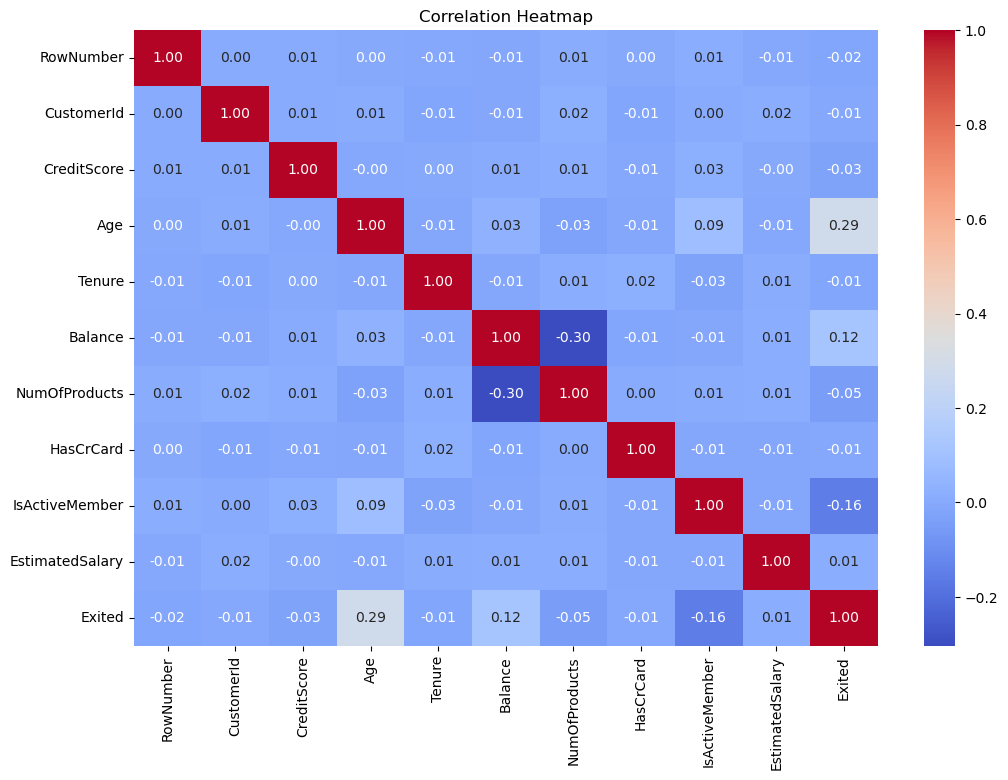

In [4]:
# Drop non-numeric columns
numeric_df = df.select_dtypes(include='number')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

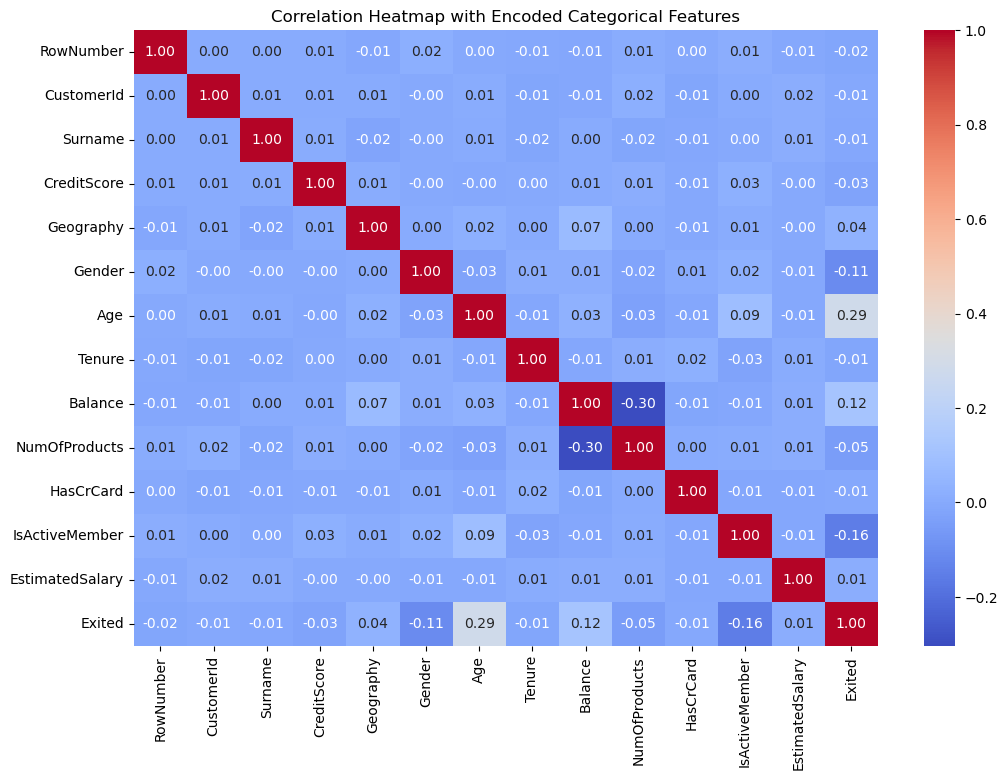

In [5]:
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object'):
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap with Encoded Categorical Features")
plt.show()

In [6]:
# Drop irrelevant features
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = df['Exited']

# Encode categorical variables
X['Gender'] = LabelEncoder().fit_transform(X['Gender'])
X = pd.get_dummies(X, columns=['Geography'], drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [7]:
# Build the ANN model
model = Sequential([
    Input(shape=(X_train.shape[1],)),         # Proper way to define input shape
    Dense(units=6, activation='relu'),
    Dense(units=6, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)

# Predict and evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Confusion Matrix:
 [[1513   82]
 [ 194  211]]
Accuracy: 0.862


PermutationExplainer explainer: 101it [00:16,  3.10it/s]                                                               


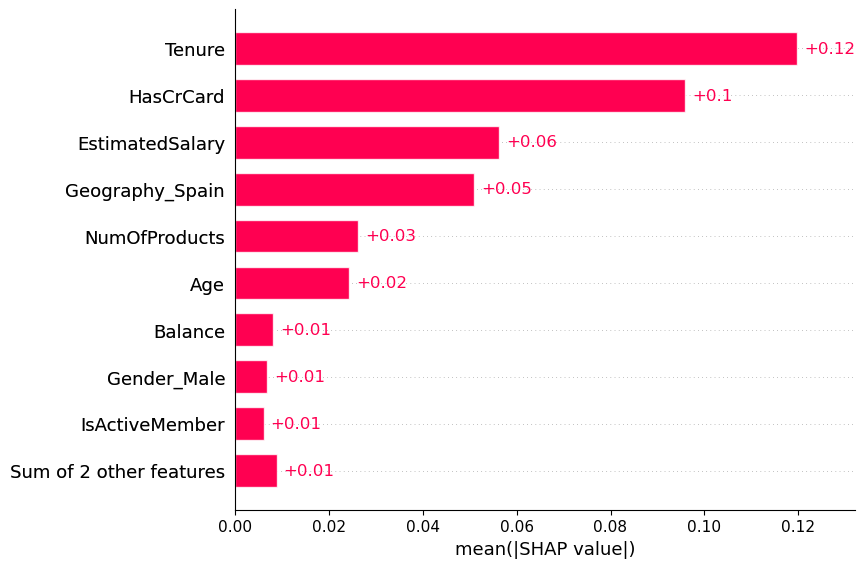

In [8]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)

# Reconstruct feature names
feature_names = pd.get_dummies(df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']), 
                                columns=['Geography', 'Gender'], drop_first=True).columns

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_test_df[:100])

shap.plots.bar(shap_values, max_display=10)
